In [1]:
from spektral.layers import GCNConv, TAGConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2
import pandas as pd

In [2]:
import numpy as np
import scipy.sparse as sp
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from spektral.data import Dataset, DisjointLoader, Graph
from spektral.layers import GCSConv, GlobalAvgPool, ChebConv, GlobalSumPool, GraphSageConv
from spektral.layers.pooling import TopKPool
from spektral.transforms.normalize_adj import NormalizeAdj
import pickle as pkl
import networkx as nx
import pdb
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from spektral.layers import GCNConv, GraphSageConv
from spektral.models.gcn import GCN
from spektral.transforms import AdjToSpTensor, LayerPreprocess
from sklearn.preprocessing import MinMaxScaler

# Preprocess data
- Read the circuit files (.x, .y, and .graph)
- Normalize the circuit level features using Min Max Scalar for each circuit
- Generate the adjacency matrix from graph dictionary


In [3]:

batch_size = 3  # Batch size

import sys
from spektral.data import Dataset, Graph
# sys.path.append('../lib')
# from data_pre_processing import load_data
# sys.path.remove('../lib')

x_data = []
y_data = []

def load_data(circuit_name, path_to_data="data", normalize=False):
    """Load data."""
    names = ["x", "y", "graph"]
    objects = []
    for i in range(len(names)):
        with open(f"{path_to_data}/{circuit_name}.{names[i]}", "rb") as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding="latin1"))
            else:
                objects.append(pkl.load(f))

    x, y, graph = tuple(objects)
    
    x = np.array(x).astype("float32")
    for x_feat in x:
        x_data.append(x_feat)
        
    features = sp.csr_matrix(x).astype('float32')
    # adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph)).astype(int)
    g = nx.DiGraph()
    g.add_nodes_from(graph.keys())
    for k, v in graph.items():
      g.add_edges_from(([(k, t) for t in v]))
      g.add_edges_from([(k, k)])
    adj = nx.adjacency_matrix(g)
    labels = np.array(y).astype('float32').reshape((-1,1))
    for l in y:
        y_data.append(l)
    print(adj.shape)
    print(features.shape)
    return adj, features, labels
  
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels


def _preprocess_features(features):
    rowsum = np.array(features.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.0
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features



class CircuitDataset(Dataset):
    def read(self):
        circuits = []
        circs = ["adder.bench","arbiter.bench","c1355","c1908","c3540","c432","c499","c5315","c6288","c880","cavlc.bench","ctrl","dec.bench","i2c","int2float.bench","max.bench","multiplier.bench","priority.bench","router","sin.bench","voter.bench"]
        for circ in circs:
            A, X, labels = load_data(circ, 'data/output', normalize="")
            print(f"{circ}: {sum(labels)}, {len(labels)}")
            scaler = MinMaxScaler()
            X = scaler.fit_transform(X.toarray())
            circuits.append(Graph(x=X, a=A, y=labels))

        return circuits




# Initialize dataset and split into train, test, and validation

In [4]:
dataset = CircuitDataset(transforms=[LayerPreprocess(TAGConv)])

# Parameters

F = dataset.n_node_features  # Dimension of node features
n_out = dataset.n_labels  # Dimension of the target

# Train/valid/test split
np.random.seed(42)
idxs = np.random.permutation(len(dataset))
split_va, split_te = int(0.8 * len(dataset)), int(0.9 * len(dataset))
idx_tr, idx_va, idx_te = np.split(idxs, [split_va, split_te])
print(idx_tr, idx_va, idx_te)
dataset_tr = dataset[idx_tr]
dataset_va = dataset[idx_va]
dataset_te = dataset[idx_te]
def load_tr_data(epochs=400):
    loader_tr = DisjointLoader(dataset_tr, batch_size=batch_size, epochs=epochs, node_level=True)
    loader_va = DisjointLoader(dataset_va, batch_size=batch_size, node_level=True)
    loader_te = DisjointLoader(dataset_te, batch_size=batch_size, node_level=True)
    return loader_tr, loader_va, loader_te

loader_tr, loader_va, loader_te = load_tr_data()


(4209, 4209)
(4209, 4)
adder.bench: [637.], 4209
(36352, 36352)
(36352, 4)
arbiter.bench: [3763.], 36352
(1355, 1355)
(1355, 4)
c1355: [192.], 1355
(1908, 1908)
(1908, 4)
c1908: [257.], 1908
(3540, 3540)
(3540, 4)
c3540: [406.], 3540
(432, 432)
(432, 4)
c432: [60.], 432
(499, 499)
(499, 4)
c499: [50.], 499
(5315, 5315)
(5315, 4)
c5315: [599.], 5315
(6288, 6288)
(6288, 4)
c6288: [846.], 6288
(880, 880)
(880, 4)
c880: [114.], 880
(2164, 2164)
(2164, 4)
cavlc.bench: [318.], 2164
(569, 569)
(569, 4)
ctrl: [92.], 569
(936, 936)
(936, 4)
dec.bench: [186.], 936
(4107, 4107)
(4107, 4)
i2c: [502.], 4107
(761, 761)
(761, 4)
int2float.bench: [80.], 761
(9996, 9996)
(9996, 4)
max.bench: [1040.], 9996
(89943, 89943)
(89943, 4)
multiplier.bench: [9294.], 89943
(3495, 3495)
(3495, 4)
priority.bench: [350.], 3495
(945, 945)
(945, 4)
router: [99.], 945
(16771, 16771)
(16771, 4)
sin.bench: [1723.], 16771
(50122, 50122)
(50122, 4)
voter.bench: [5012.], 50122
[ 0 17 15  1  8  5 11  3 18 16 13  2  9 20  4 

# Normalized Input Distribution

In [5]:
dataset_tr[0]

Graph(n_nodes=4209, n_node_features=4, n_edge_features=None, n_labels=1)

In [6]:
# for i, g in enumerate(dataset):
#     print(f"----------------{i}-----------------")
#     df_all_circ_data = pd.DataFrame(g.x, columns=['level', 'c0', 'c1', 'ob'])
#     df_all_circ_data['y'] = g.y
#     for col in ['level', 'c0', 'c1', 'ob']:
#         df_all_circ_data.hist(by='y', column=col, sharex=True, sharey=True)
#         plt.suptitle(col)
#         plt.show()

In [7]:
N = sum([ g.n_nodes for g in dataset.graphs ])
n_out = 1
N

240587

# Compute class weight for unbalanced labels

In [8]:
from sklearn.utils.class_weight import compute_class_weight

y_data = []
for data_tr in dataset_tr:
    y_data.append(data_tr.y)
y_data = np.vstack((y_data)).reshape((-1,))


def _compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y).astype('float32')
    class_weight = compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, class_weight))
    return class_weight_dict 

weights = _compute_class_weight_dictionary(np.vstack((y_data)).reshape((-1,)))
print(weights)

{0.0: 0.5594349389003626, 1.0: 4.706280087527352}


/Users/nikitaacharya/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass classes=[0. 1.], y=[0. 0. 0. ... 0. 0. 0.] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


In [9]:
%load_ext tensorboard

# Topology Aware Graph Convolution Network Model (TAGConv)

In [62]:
from tensorflow.keras.metrics import sparse_categorical_accuracy, binary_accuracy, binary_crossentropy
from tensorflow.keras import activations
from tensorflow.keras import layers

channels = 256         # Number of channels in the first layer
dropout = 0.05         # Dropout rate for the features
l2_reg = 1e-4           # L2 regularization rate
learning_rate = 1e-5    # Learning rate
epochs = 500            # Number of training epochs
es_patience = 10    
patience = 30 # Patience for early stopping
# N = 

# Model definition
X_in = Input(shape=(F, ))
print("X_in: ", X_in.shape)
fltr_in = Input((None, ), sparse=True)
mask_in = Input((None, ))

use_bias = True
x = TAGConv(128, K=10, aggregate="sum",
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv1")([X_in, fltr_in]) 
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x1 = TAGConv(256, k = 5, aggregate="mean",
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv2")([x, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
# x = TAGConv(256, k = 5, aggregate="sum",
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv3")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
x = GraphSageConv(128, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv3")([X_in, fltr_in])
x = BatchNormalization()(x)
x = Dropout(dropout)(x)
x2 = GraphSageConv(128, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="conv4")([x, fltr_in])

# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(128, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv5")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(64, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv6")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(32, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv7")([x, fltr_in])
# x = BatchNormalization()(x)
# x = Dropout(dropout)(x)
# x = GraphSageConv(4, aggregate_op='sum',
#                          dropout_rate=dropout,
#                          activation='relu',
#                          kernel_regularizer=l2(l2_reg),
#                          attn_kernel_regularizer=l2(l2_reg),
#                          bias_regularizer=l2(l2_reg),
#                          use_bias=use_bias,
#                          n_input_channels=dataset.n_node_features, name="conv8")([x, fltr_in])
x3 = GCNConv(128, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="gcn")([X_in, fltr_in])
x = GCNConv(128, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="gcn")([x3, fltr_in])
x = GCNConv(128, aggregate_op='sum',
                         dropout_rate=dropout,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         attn_kernel_regularizer=l2(l2_reg),
                         bias_regularizer=l2(l2_reg),
                         use_bias=use_bias,
                         n_input_channels=dataset.n_node_features, name="gcn")([x, fltr_in])
concatted = tf.keras.layers.Concatenate()([x1, x2, x3])
flattened = tf.keras.layers.Flatten()(concatted)
fl1 = tf.keras.layers.Dense(128, activation='relu')(flattened)
x = Dropout(dropout)(fl1)
x = tf.keras.layers.Dense(n_out, activation='sigmoid', name="classification")(x)
# x = GCNConv(n_out, activation='sigmoid',
#                          n_input_channels=dataset.n_node_features, name="classification", use_bias=use_bias)([x, fltr_in])

model = Model(inputs=[X_in, fltr_in, mask_in], outputs=x)
optimizer = Adam(lr=learning_rate)

def masked_loss_and_accuracy(target, predictions):
    loss = binary_crossentropy(target, predictions)
    minimum = tf.math.minimum(tf.reduce_sum(tf.dtypes.cast(target == 0, tf.int32)), tf.reduce_sum(tf.dtypes.cast(target == 1, tf.int32)))
    zeroes_index = tf.random.shuffle(tf.where(target == 0)[:,0])
    ones_index = tf.random.shuffle(tf.where(target == 1)[:,0])
    loss_zeroes =  tf.reduce_mean(tf.gather(loss, zeroes_index))
    loss_ones = tf.reduce_mean(tf.gather(loss, ones_index))
    
    weight_for_0 = tf.cast((1 / tf.shape(zeroes_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')
    weight_for_1 = tf.cast((1 / tf.shape(ones_index)[0])*(tf.cast(tf.shape(target)[0], 'float64'))/2.0, 'float32')

    return (weight_for_0 * loss_zeroes * 0.6 +  weight_for_1 * loss_ones * 0.4)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              weighted_metrics=['acc', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
model.summary()

import tempfile
tfcallback_dir = tempfile.TemporaryDirectory(suffix='tf', prefix='', dir=None).name
tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
        log_dir=tfcallback_dir,
        histogram_freq=1
)
# 
callback_GCN = [tbCallBack_GCN, EarlyStopping(patience=patience, restore_best_weights=True)]

X_in:  (None, 4)
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           [(None, 4)]          0                                            
__________________________________________________________________________________________________
input_17 (InputLayer)           [(None, None)]       0                                            
__________________________________________________________________________________________________
conv1 (TAGConv)                 (None, 128)          5760        input_16[0][0]                   
                                                                 input_17[0][0]                   
__________________________________________________________________________________________________
conv3 (GraphSageConv)           (None, 128)          1152        input_16[0

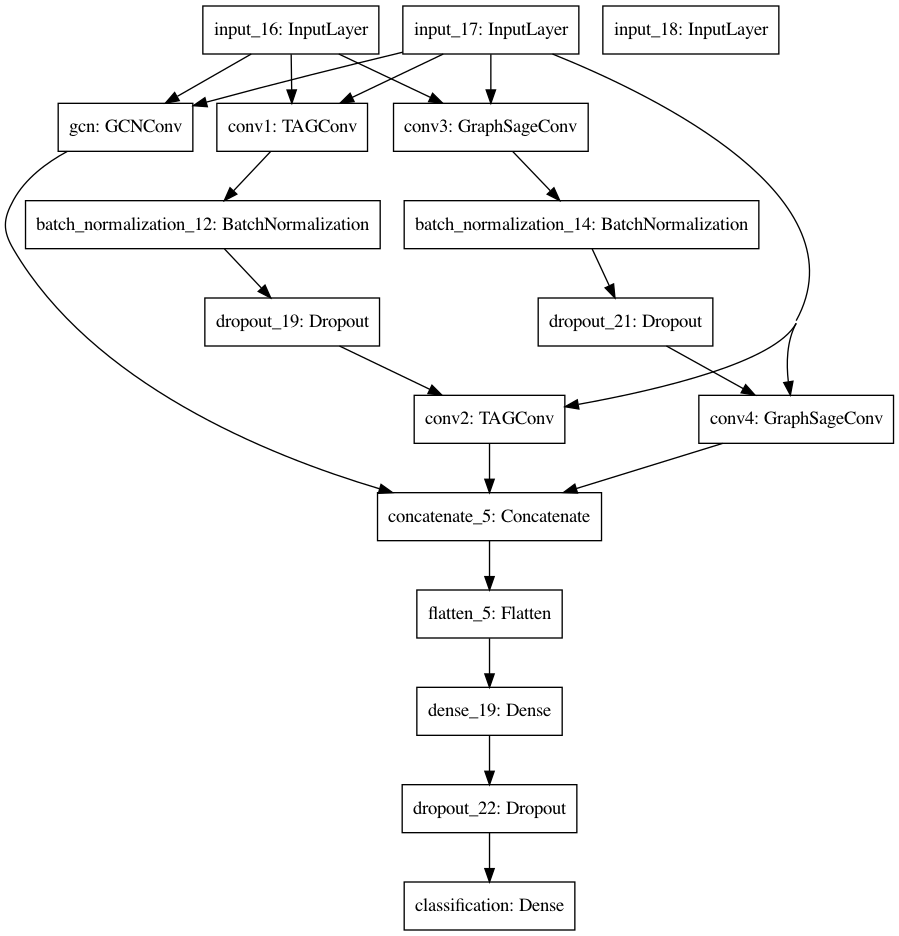

In [63]:
tf.keras.utils.plot_model(
    model,
    show_layer_names=True,
    rankdir="TB",
    dpi=96,
)

# Train the model

In [64]:
epochs = 500
loader_tr, loader_va, loader_te = load_tr_data(epochs)
# class_weight = {0: 0.11, 1: 0.89}
history = model.fit(
    loader_tr.load(),
    steps_per_epoch=loader_tr.steps_per_epoch,
    validation_data=loader_va.load(),
    validation_steps=loader_va.steps_per_epoch,
    epochs=epochs,
    class_weight=weights,
    callbacks=callback_GCN
)

Epoch 1/500
6/6 [==============================] - 9s 1s/step - loss: 0.7626 - acc: 0.5276 - precision_5: 0.5185 - recall_5: 0.9588 - val_loss: 0.7702 - val_acc: 0.1500 - val_precision_5: 0.1256 - val_recall_5: 0.9945
Epoch 2/500
6/6 [==============================] - 4s 762ms/step - loss: 0.7665 - acc: 0.5146 - precision_5: 0.5130 - recall_5: 0.9358 - val_loss: 0.7713 - val_acc: 0.1416 - val_precision_5: 0.1247 - val_recall_5: 0.9967
Epoch 3/500
6/6 [==============================] - 4s 773ms/step - loss: 0.7505 - acc: 0.5307 - precision_5: 0.5206 - recall_5: 0.9677 - val_loss: 0.7720 - val_acc: 0.1385 - val_precision_5: 0.1244 - val_recall_5: 0.9978
Epoch 4/500
6/6 [==============================] - 4s 747ms/step - loss: 0.7393 - acc: 0.5319 - precision_5: 0.5210 - recall_5: 0.9730 - val_loss: 0.7725 - val_acc: 0.1369 - val_precision_5: 0.1244 - val_recall_5: 1.0000
Epoch 5/500
6/6 [==============================] - 4s 784ms/step - loss: 0.7528 - acc: 0.5459 - precision_5: 0.5326 - r

Epoch 38/500
6/6 [==============================] - 4s 453ms/step - loss: 0.6262 - acc: 0.7367 - precision_5: 0.6637 - recall_5: 0.9653 - val_loss: 0.6984 - val_acc: 0.7123 - val_precision_5: 0.2973 - val_recall_5: 0.9880
Epoch 39/500
6/6 [==============================] - 4s 767ms/step - loss: 0.6326 - acc: 0.7334 - precision_5: 0.6623 - recall_5: 0.9668 - val_loss: 0.6942 - val_acc: 0.7147 - val_precision_5: 0.2990 - val_recall_5: 0.9869
Epoch 40/500
6/6 [==============================] - 4s 777ms/step - loss: 0.6307 - acc: 0.7115 - precision_5: 0.6496 - recall_5: 0.9316 - val_loss: 0.6900 - val_acc: 0.7187 - val_precision_5: 0.3013 - val_recall_5: 0.9815
Epoch 41/500
6/6 [==============================] - 4s 789ms/step - loss: 0.6327 - acc: 0.7245 - precision_5: 0.6519 - recall_5: 0.9790 - val_loss: 0.6864 - val_acc: 0.7219 - val_precision_5: 0.3035 - val_recall_5: 0.9793
Epoch 42/500
6/6 [==============================] - 4s 458ms/step - loss: 0.6181 - acc: 0.7402 - precision_5: 0.

Epoch 75/500
6/6 [==============================] - 4s 587ms/step - loss: 0.5791 - acc: 0.7506 - precision_5: 0.6864 - recall_5: 0.9184 - val_loss: 0.5553 - val_acc: 0.7676 - val_precision_5: 0.3384 - val_recall_5: 0.9378
Epoch 76/500
6/6 [==============================] - 4s 809ms/step - loss: 0.6075 - acc: 0.7199 - precision_5: 0.6615 - recall_5: 0.9189 - val_loss: 0.5519 - val_acc: 0.7690 - val_precision_5: 0.3398 - val_recall_5: 0.9378
Epoch 77/500
6/6 [==============================] - 4s 767ms/step - loss: 0.5793 - acc: 0.7854 - precision_5: 0.7250 - recall_5: 0.9246 - val_loss: 0.5480 - val_acc: 0.7696 - val_precision_5: 0.3401 - val_recall_5: 0.9346
Epoch 78/500
6/6 [==============================] - 4s 742ms/step - loss: 0.5873 - acc: 0.7558 - precision_5: 0.7006 - recall_5: 0.9053 - val_loss: 0.5452 - val_acc: 0.7711 - val_precision_5: 0.3417 - val_recall_5: 0.9357
Epoch 79/500
6/6 [==============================] - 4s 767ms/step - loss: 0.5711 - acc: 0.7929 - precision_5: 0.

Epoch 112/500
6/6 [==============================] - 4s 759ms/step - loss: 0.5592 - acc: 0.7423 - precision_5: 0.6853 - recall_5: 0.9340 - val_loss: 0.4724 - val_acc: 0.7938 - val_precision_5: 0.3702 - val_recall_5: 0.9716
Epoch 113/500
6/6 [==============================] - 4s 612ms/step - loss: 0.5514 - acc: 0.7945 - precision_5: 0.7407 - recall_5: 0.9064 - val_loss: 0.4721 - val_acc: 0.7932 - val_precision_5: 0.3697 - val_recall_5: 0.9749
Epoch 114/500
6/6 [==============================] - 4s 779ms/step - loss: 0.5399 - acc: 0.7526 - precision_5: 0.6865 - recall_5: 0.9381 - val_loss: 0.4705 - val_acc: 0.7925 - val_precision_5: 0.3690 - val_recall_5: 0.9749
Epoch 115/500
6/6 [==============================] - 4s 266ms/step - loss: 0.5420 - acc: 0.7299 - precision_5: 0.6556 - recall_5: 0.9630 - val_loss: 0.4710 - val_acc: 0.7902 - val_precision_5: 0.3665 - val_recall_5: 0.9760
Epoch 116/500
6/6 [==============================] - 4s 674ms/step - loss: 0.5290 - acc: 0.8074 - precision_

Epoch 149/500
6/6 [==============================] - 4s 663ms/step - loss: 0.4907 - acc: 0.8423 - precision_5: 0.7999 - recall_5: 0.9163 - val_loss: 0.4314 - val_acc: 0.8025 - val_precision_5: 0.3809 - val_recall_5: 0.9760
Epoch 150/500
6/6 [==============================] - 5s 936ms/step - loss: 0.5542 - acc: 0.7733 - precision_5: 0.7184 - recall_5: 0.9468 - val_loss: 0.4303 - val_acc: 0.8032 - val_precision_5: 0.3817 - val_recall_5: 0.9760
Epoch 151/500
6/6 [==============================] - 4s 811ms/step - loss: 0.4997 - acc: 0.8154 - precision_5: 0.7509 - recall_5: 0.9506 - val_loss: 0.4301 - val_acc: 0.8029 - val_precision_5: 0.3814 - val_recall_5: 0.9771
Epoch 152/500
6/6 [==============================] - 4s 801ms/step - loss: 0.4944 - acc: 0.8205 - precision_5: 0.7561 - recall_5: 0.9527 - val_loss: 0.4289 - val_acc: 0.8034 - val_precision_5: 0.3820 - val_recall_5: 0.9760
Epoch 153/500
6/6 [==============================] - 4s 771ms/step - loss: 0.4981 - acc: 0.8542 - precision_

Epoch 186/500
6/6 [==============================] - 4s 457ms/step - loss: 0.4802 - acc: 0.8215 - precision_5: 0.7680 - recall_5: 0.9209 - val_loss: 0.3969 - val_acc: 0.8202 - val_precision_5: 0.4019 - val_recall_5: 0.9564
Epoch 187/500
6/6 [==============================] - 4s 764ms/step - loss: 0.4691 - acc: 0.8672 - precision_5: 0.8114 - recall_5: 0.9702 - val_loss: 0.3958 - val_acc: 0.8203 - val_precision_5: 0.4021 - val_recall_5: 0.9564
Epoch 188/500
6/6 [==============================] - 4s 813ms/step - loss: 0.4836 - acc: 0.7739 - precision_5: 0.7012 - recall_5: 0.9695 - val_loss: 0.3964 - val_acc: 0.8198 - val_precision_5: 0.4013 - val_recall_5: 0.9553
Epoch 189/500
6/6 [==============================] - 4s 687ms/step - loss: 0.4638 - acc: 0.8382 - precision_5: 0.7953 - recall_5: 0.9133 - val_loss: 0.3931 - val_acc: 0.8223 - val_precision_5: 0.4045 - val_recall_5: 0.9520
Epoch 190/500
6/6 [==============================] - 4s 810ms/step - loss: 0.4788 - acc: 0.8329 - precision_

Epoch 223/500
6/6 [==============================] - 4s 254ms/step - loss: 0.4739 - acc: 0.7707 - precision_5: 0.6933 - recall_5: 0.9655 - val_loss: 0.3823 - val_acc: 0.8243 - val_precision_5: 0.4061 - val_recall_5: 0.9368
Epoch 224/500
6/6 [==============================] - 4s 770ms/step - loss: 0.4617 - acc: 0.8363 - precision_5: 0.7774 - recall_5: 0.9526 - val_loss: 0.3811 - val_acc: 0.8254 - val_precision_5: 0.4075 - val_recall_5: 0.9346
Epoch 225/500
6/6 [==============================] - 4s 594ms/step - loss: 0.4379 - acc: 0.8608 - precision_5: 0.8148 - recall_5: 0.9409 - val_loss: 0.3804 - val_acc: 0.8255 - val_precision_5: 0.4077 - val_recall_5: 0.9346
Epoch 226/500
6/6 [==============================] - 4s 565ms/step - loss: 0.4365 - acc: 0.8601 - precision_5: 0.8071 - recall_5: 0.9491 - val_loss: 0.3784 - val_acc: 0.8263 - val_precision_5: 0.4085 - val_recall_5: 0.9302
Epoch 227/500
6/6 [==============================] - 4s 445ms/step - loss: 0.4519 - acc: 0.8417 - precision_

Epoch 260/500
6/6 [==============================] - 4s 748ms/step - loss: 0.4509 - acc: 0.8518 - precision_5: 0.8066 - recall_5: 0.9488 - val_loss: 0.3639 - val_acc: 0.8322 - val_precision_5: 0.4160 - val_recall_5: 0.9128
Epoch 261/500
6/6 [==============================] - 4s 265ms/step - loss: 0.4724 - acc: 0.7794 - precision_5: 0.7136 - recall_5: 0.9294 - val_loss: 0.3660 - val_acc: 0.8310 - val_precision_5: 0.4143 - val_recall_5: 0.9149
Epoch 262/500
6/6 [==============================] - 4s 767ms/step - loss: 0.4447 - acc: 0.8348 - precision_5: 0.7826 - recall_5: 0.9496 - val_loss: 0.3663 - val_acc: 0.8303 - val_precision_5: 0.4131 - val_recall_5: 0.9128
Epoch 263/500
6/6 [==============================] - 4s 593ms/step - loss: 0.4205 - acc: 0.8768 - precision_5: 0.8497 - recall_5: 0.9304 - val_loss: 0.3634 - val_acc: 0.8317 - val_precision_5: 0.4149 - val_recall_5: 0.9095
Epoch 264/500
6/6 [==============================] - 4s 803ms/step - loss: 0.4495 - acc: 0.8420 - precision_

Epoch 297/500
6/6 [==============================] - 4s 751ms/step - loss: 0.4019 - acc: 0.8702 - precision_5: 0.8465 - recall_5: 0.9078 - val_loss: 0.3491 - val_acc: 0.8386 - val_precision_5: 0.4229 - val_recall_5: 0.8670
Epoch 298/500
6/6 [==============================] - 4s 442ms/step - loss: 0.4458 - acc: 0.8362 - precision_5: 0.7735 - recall_5: 0.9546 - val_loss: 0.3468 - val_acc: 0.8416 - val_precision_5: 0.4269 - val_recall_5: 0.8528
Epoch 299/500
6/6 [==============================] - 4s 788ms/step - loss: 0.4340 - acc: 0.8386 - precision_5: 0.7796 - recall_5: 0.9494 - val_loss: 0.3445 - val_acc: 0.8446 - val_precision_5: 0.4315 - val_recall_5: 0.8419
Epoch 300/500
6/6 [==============================] - 4s 798ms/step - loss: 0.4558 - acc: 0.8404 - precision_5: 0.8009 - recall_5: 0.9186 - val_loss: 0.3432 - val_acc: 0.8450 - val_precision_5: 0.4310 - val_recall_5: 0.8244
Epoch 301/500
6/6 [==============================] - 4s 617ms/step - loss: 0.3938 - acc: 0.8862 - precision_

Epoch 334/500
6/6 [==============================] - 4s 441ms/step - loss: 0.4338 - acc: 0.8412 - precision_5: 0.7747 - recall_5: 0.9689 - val_loss: 0.3296 - val_acc: 0.8523 - val_precision_5: 0.4442 - val_recall_5: 0.8168
Epoch 335/500
6/6 [==============================] - 4s 784ms/step - loss: 0.4002 - acc: 0.8699 - precision_5: 0.8149 - recall_5: 0.9690 - val_loss: 0.3299 - val_acc: 0.8520 - val_precision_5: 0.4441 - val_recall_5: 0.8233
Epoch 336/500
6/6 [==============================] - 4s 457ms/step - loss: 0.4499 - acc: 0.8338 - precision_5: 0.7826 - recall_5: 0.9302 - val_loss: 0.3291 - val_acc: 0.8544 - val_precision_5: 0.4488 - val_recall_5: 0.8222
Epoch 337/500
6/6 [==============================] - 4s 785ms/step - loss: 0.3940 - acc: 0.8794 - precision_5: 0.8540 - recall_5: 0.9326 - val_loss: 0.3286 - val_acc: 0.8553 - val_precision_5: 0.4505 - val_recall_5: 0.8190
Epoch 338/500
6/6 [==============================] - 4s 499ms/step - loss: 0.4378 - acc: 0.8386 - precision_

Epoch 371/500
6/6 [==============================] - 4s 777ms/step - loss: 0.3837 - acc: 0.8748 - precision_5: 0.8300 - recall_5: 0.9521 - val_loss: 0.3242 - val_acc: 0.8545 - val_precision_5: 0.4472 - val_recall_5: 0.7895
Epoch 372/500
6/6 [==============================] - 4s 623ms/step - loss: 0.3833 - acc: 0.8809 - precision_5: 0.8713 - recall_5: 0.9009 - val_loss: 0.3224 - val_acc: 0.8569 - val_precision_5: 0.4517 - val_recall_5: 0.7808
Epoch 373/500
6/6 [==============================] - 4s 638ms/step - loss: 0.3501 - acc: 0.8937 - precision_5: 0.8512 - recall_5: 0.9603 - val_loss: 0.3201 - val_acc: 0.8612 - val_precision_5: 0.4607 - val_recall_5: 0.7743
Epoch 374/500
6/6 [==============================] - 4s 295ms/step - loss: 0.4331 - acc: 0.8325 - precision_5: 0.7914 - recall_5: 0.8992 - val_loss: 0.3214 - val_acc: 0.8607 - val_precision_5: 0.4596 - val_recall_5: 0.7754
Epoch 375/500
6/6 [==============================] - 4s 338ms/step - loss: 0.4495 - acc: 0.8374 - precision_

Epoch 408/500
6/6 [==============================] - 4s 810ms/step - loss: 0.4169 - acc: 0.8533 - precision_5: 0.8849 - recall_5: 0.8282 - val_loss: 0.3183 - val_acc: 0.8651 - val_precision_5: 0.4703 - val_recall_5: 0.7939
Epoch 409/500
6/6 [==============================] - 4s 829ms/step - loss: 0.3638 - acc: 0.8876 - precision_5: 0.8725 - recall_5: 0.9232 - val_loss: 0.3179 - val_acc: 0.8650 - val_precision_5: 0.4698 - val_recall_5: 0.7884
Epoch 410/500
6/6 [==============================] - 4s 785ms/step - loss: 0.3690 - acc: 0.8861 - precision_5: 0.8480 - recall_5: 0.9496 - val_loss: 0.3190 - val_acc: 0.8636 - val_precision_5: 0.4668 - val_recall_5: 0.7906
Epoch 411/500
6/6 [==============================] - 4s 630ms/step - loss: 0.3346 - acc: 0.8917 - precision_5: 0.8582 - recall_5: 0.9439 - val_loss: 0.3170 - val_acc: 0.8680 - val_precision_5: 0.4768 - val_recall_5: 0.7830
Epoch 412/500
6/6 [==============================] - 4s 777ms/step - loss: 0.3602 - acc: 0.8974 - precision_

In [65]:
import os
import tensorflow as tf
# import tensorflow_datasets as tfds
from tensorboard.plugins import projector

In [66]:
%tensorboard --logdir {tfcallback_dir}

In [67]:
model_loss = model.evaluate(loader_te.load(), steps=loader_te.steps_per_epoch)
print("Done. Test loss: {}".format(model_loss))

1/1 [==============================] - 0s 130ms/step - loss: 0.3785 - acc: 0.8977 - precision_5: 0.5080 - recall_5: 0.1376
Done. Test loss: [0.3785382807254791, 0.8976762294769287, 0.5079681277275085, 0.1376146823167801]


# Model prediction metrics

In [68]:
from sklearn.metrics import classification_report
print(len(dataset_te))
for test_data in dataset_te:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

3
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.73      0.84       449
         1.0       0.29      1.00      0.45        50

    accuracy                           0.76       499
   macro avg       0.65      0.87      0.65       499
weighted avg       0.93      0.76      0.81       499

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.90      1.00      0.95     15048
         1.0       1.00      0.07      0.14      1723

    accuracy                           0.90     16771
   macro avg       0.95      0.54      0.54     16771
weighted avg       0.91      0.90      0.87     16771

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.81      0.90       681
         1.0       0.39      0.99      0.55        80

    accuracy                           0.83       761
   macro avg       0.69      0.90      

In [69]:
from sklearn.metrics import classification_report
print(len(dataset_va))
for test_data in dataset_va:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

2
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      4716
         1.0       0.85      0.67      0.75       599

    accuracy                           0.95      5315
   macro avg       0.90      0.83      0.86      5315
weighted avg       0.95      0.95      0.95      5315

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.98      0.65      0.78      1846
         1.0       0.31      0.92      0.46       318

    accuracy                           0.69      2164
   macro avg       0.64      0.78      0.62      2164
weighted avg       0.88      0.69      0.74      2164



In [70]:
from sklearn.metrics import classification_report
print(len(dataset_tr))
for test_data in dataset_tr:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = classification_report(y_te, (y_pred >= 0.5).astype(int))
    print('GCN Classification Report: \n {}'.format(report))

16
GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.93      0.22      0.35       750
         1.0       0.23      0.94      0.37       186

    accuracy                           0.36       936
   macro avg       0.58      0.58      0.36       936
weighted avg       0.79      0.36      0.36       936

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      0.60      0.75     32589
         1.0       0.22      1.00      0.37      3763

    accuracy                           0.64     36352
   macro avg       0.61      0.80      0.56     36352
weighted avg       0.92      0.64      0.71     36352

GCN Classification Report: 
               precision    recall  f1-score   support

         0.0       0.94      1.00      0.97      3134
         1.0       1.00      0.55      0.71       406

    accuracy                           0.95      3540
   macro avg       0.97      0.77     

# Model layers output using TSNE

In [71]:
from sklearn.manifold import TSNE
test_data = dataset_te[2]
X_te = test_data.x
A_te = test_data.a
y_te = test_data.y

layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X_te,A_te, A_te],batch_size=X_te.shape[0])


In [72]:
from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

num_classes = 2
def plot_tSNE(labels_encoded,x_tsne):
    color_map = labels_encoded
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl, alpha=0.5)
    plt.legend()
    plt.show()

In [73]:
print(model.layers)

[<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb800751320>, <tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb800751588>, <spektral.layers.convolutional.tag_conv.TAGConv object at 0x7fb800751cc0>, <spektral.layers.convolutional.graphsage_conv.GraphSageConv object at 0x7fb95cbe4b00>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb800760828>, <tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb95cc03a90>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fb940849c18>, <tensorflow.python.keras.layers.core.Dropout object at 0x7fb95d2af828>, <spektral.layers.convolutional.tag_conv.TAGConv object at 0x7fb940845ac8>, <spektral.layers.convolutional.graphsage_conv.GraphSageConv object at 0x7fb95d2bd588>, <spektral.layers.convolutional.gcn_conv.GCNConv object at 0x7fb95d2916d8>, <tensorflow.python.keras.layers.merge.Concatenate object at 0x7fb93faa2ac8>, <tensorflow.python.keras.

13


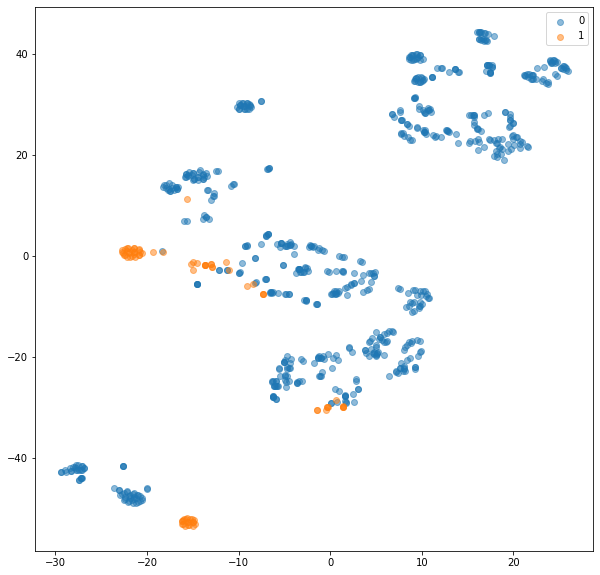

16


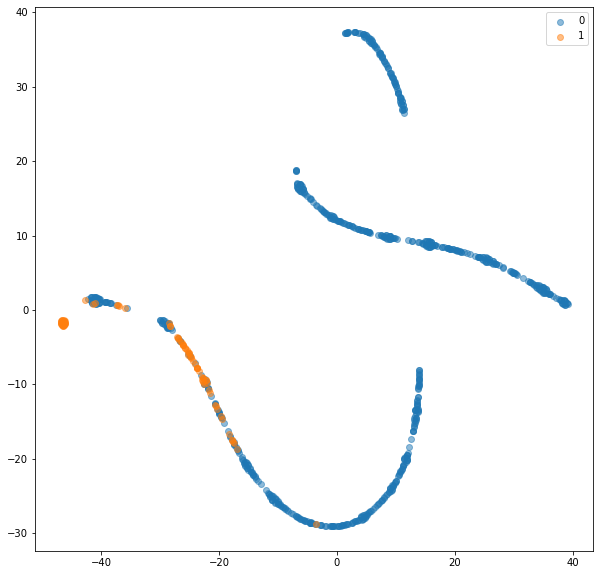

In [74]:
for i, layer in enumerate(model.layers):
#     if isinstance(layer, TAGConv) or isinstance(layer, GraphSageConv) or isinstance(layer, Dense):
    if isinstance(layer, Dense):
        print(i)
        x_tsne17 = TSNE(n_components=2).fit_transform(activations[i]) 
        plot_tSNE(y_te,x_tsne17)

In [75]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(predicted_labels_list, y_test_list):
    cnf_matrix = confusion_matrix(y_test_list, predicted_labels_list)
    np.set_printoptions(precision=2)

    # Plot non-normalized confusion matrix
    plt.figure()
    generate_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix, without normalization')
    plt.show()
    
    

In [76]:
def generate_confusion_matrix(cnf_matrix, classes, normalize=False, title='Confusion matrix'):
    precision = cnf_matrix[1,1]/cnf_matrix[:,1].sum()
    recall = cnf_matrix[1,1]/cnf_matrix[1,:].sum()
    print('precision:', precision)
    print('recall:', recall)
    if normalize:
#         cnf_matrix = confusion_matrix
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cnf_matrix.max() / 2.

    for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
        plt.text(j, i, format(cnf_matrix[i, j], fmt), horizontalalignment="center",
                 color="white" if cnf_matrix[i, j] > thresh else "black")
   
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return cnf_matrix

3
precision: 1.0
recall: 0.29239766081871343
Confusion matrix, without normalization


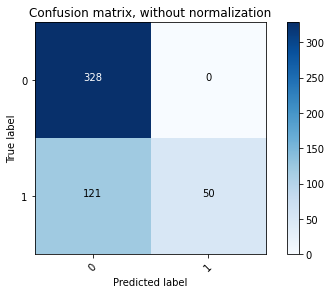

DNN Classification Report: 
 None
precision: 0.07312826465467208
recall: 1.0
Confusion matrix, without normalization


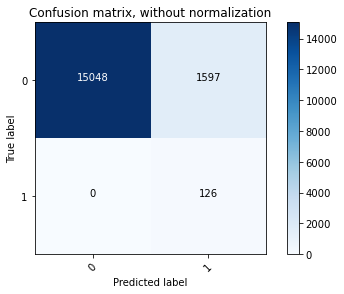

DNN Classification Report: 
 None
precision: 0.9875
recall: 0.3853658536585366
Confusion matrix, without normalization


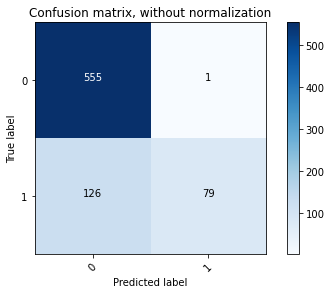

DNN Classification Report: 
 None


In [77]:
from sklearn.metrics import classification_report
import itertools

print(len(dataset_te))
class_names = ['0', '1']
for test_data in dataset_te:
    X_te = test_data.x
    A_te = test_data.a
    y_te = test_data.y

    y_pred = model.predict([X_te, A_te, A_te], batch_size=X_te.shape[0])
    report = plot_confusion_matrix(y_te, (y_pred >= 0.5).astype(int))
    print('DNN Classification Report: \n {}'.format(report))